In [1]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
from IPython.display import clear_output
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import TimeSeries, dRSA, print_wise, get_lagplot


In [2]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    sub_num = 3
    run = 1
    neu_fs = 100
    mod_fs = 23.976
    model_name = "pixelwise_lum";
    sq_side = 250
    downsampled_sq_size = 50
    sensors_group = 'occ'
    model_name = "pixelwise_luminance"
    time_points = 200
    pseudotrials_n = 100
cfg = Cfg()

In [3]:
from image_processing.gaze_dep_models import save_pixelwise_luminance
model_filename = save_pixelwise_luminance(paths, cfg.model_name, cfg.sub_num, cfg.run, cfg.mod_fs, cfg.sq_side, *(cfg.downsampled_sq_size,))
with h5py.File(model_filename, "r") as f:
    mod = f['vecrep'][:]


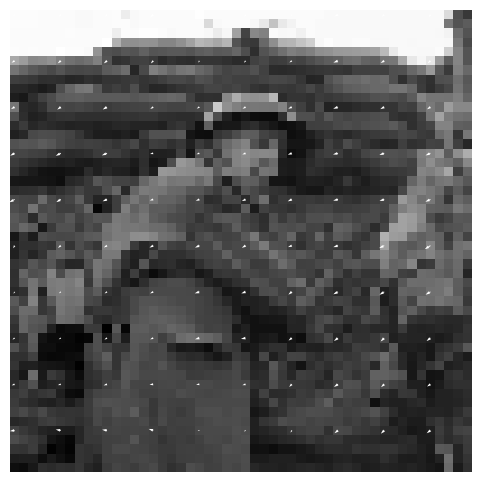

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
flow = None
for i in range(300):
    f1 = cv2.cvtColor(mod[:, i].reshape((cfg.downsampled_sq_size,cfg.downsampled_sq_size,3), order='F'), cv2.COLOR_RGB2GRAY)
    f2 = cv2.cvtColor(mod[:, i+1].reshape((cfg.downsampled_sq_size,cfg.downsampled_sq_size,3), order='F'), cv2.COLOR_RGB2GRAY)
    # Compute optical flow
    flow = cv2.calcOpticalFlowFarneback(
        f1, f2,
        flow,       # initial flow
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )

    # flow has shape (H, W, 2) — u, v displacement vectors
    u = flow[..., 0]
    v = flow[..., 1]
    mag, ang = cv2.cartToPolar(u,v)
    # Example: synthetic flow for demonstration
    H, W = 50, 50

    # Compute magnitude and angle
    mag, ang = cv2.cartToPolar(u, v, angleInDegrees=True)

    # HSV image (for visualization)
    hsv = np.zeros((H, W, 3), dtype=np.uint8)
    hsv[..., 0] = ang / 2  # Hue: 0-180
    hsv[..., 1] = 255      # Saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value

    # Convert HSV to RGB
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Plot RGB image
    plt.figure(figsize=(6, 6))
    plt.imshow(f1, cmap="gray")
    plt.axis("off")

    # Overlay vector field (subsample for clarity)
    step = 5  # plot every 5 pixels
    Y, X = np.mgrid[0:H:step, 0:W:step]
    U = u[::step, ::step]
    V = v[::step, ::step]

    plt.quiver(X, Y, U, V, color='white', angles='xy', scale_units='xy', scale=1, width=0.002)
    plt.show()
    clear_output(wait=True)
    time.sleep(.2)